## Setup Dataset

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

from datasets import load_dataset
from IPython.display import Audio

from linax.heads import RegressionHeadConfig


def print_structure(sample, indent=0):
    for k, v in sample.items():
        print(" " * indent + str(k) + ": ", end="")
        if isinstance(v, dict):
            print()
            print_structure(v, indent + 2)
        else:
            print(type(v))


def plot_spectrogram(y, sr, n_fft=1024, hop_length=128):
    """
    Plots the spectrogram of a numpy array.

    Args:
        y (np.array): Audio time series.
        sr (int): Sampling rate of y.
        n_fft (int): Length of the windowed signal after padding.
        hop_length (int): Number of audio samples between adjacent STFT columns.
    """
    plt.figure(figsize=(10, 5))

    # 1. Compute the Short-Time Fourier Transform (STFT)
    # Result is a complex-valued matrix
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # 2. Convert to decibels (Log-scale)
    # We take the magnitude of D (|D|) and convert to dB
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # 3. Visualize
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram (dB)')
    plt.show()


In [5]:
ds = load_dataset("JacobLinCool/VoiceBank-DEMAND-16k")
train_dataset, test_dataset = ds["train"], ds["test"]

first_sample = next(iter(train_dataset))
print_structure(first_sample)

id: <class 'str'>
clean: 
  path: <class 'str'>
  array: <class 'numpy.ndarray'>
  sampling_rate: <class 'int'>
noisy: 
  path: <class 'str'>
  array: <class 'numpy.ndarray'>
  sampling_rate: <class 'int'>


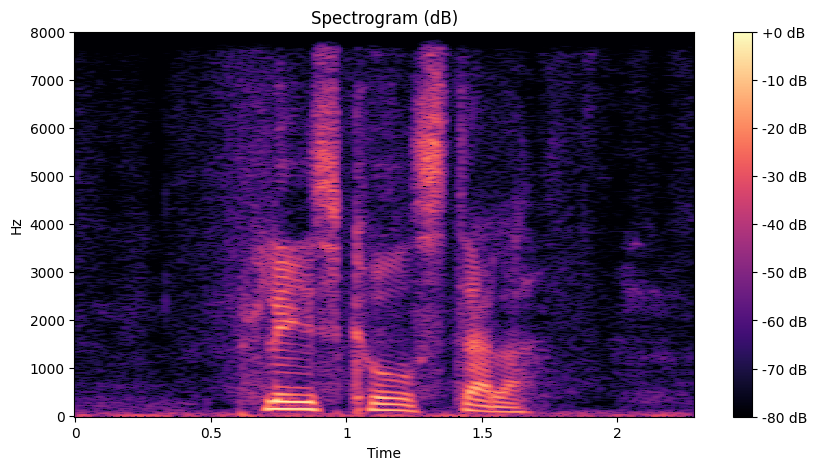

In [7]:
plot_spectrogram(first_sample["clean"]["array"], sr=16000)
Audio(first_sample["clean"]["array"], rate=16000, autoplay=True)

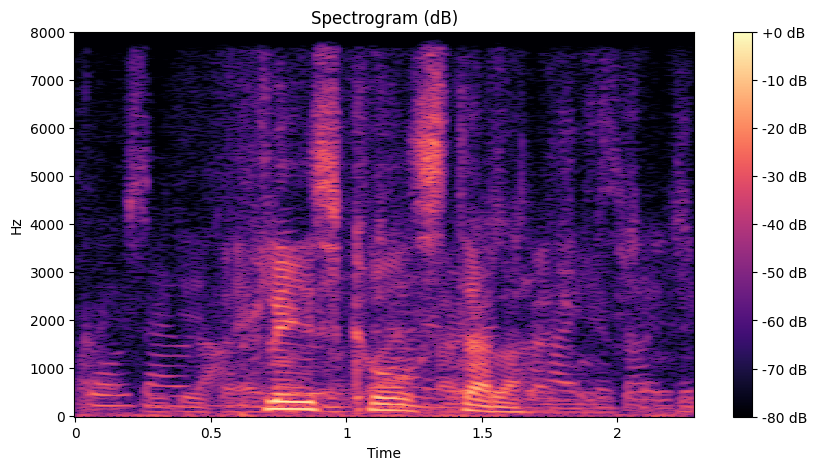

In [8]:
plot_spectrogram(first_sample["noisy"]["array"], sr=16000)
Audio(first_sample["noisy"]["array"], rate=16000, autoplay=True)

# Setup Model

In [46]:
import equinox as eqx
import jax
import jax.numpy as jnp
import optax
import torch
from jaxtyping import Array, Float, Int, PRNGKeyArray, PyTree
from tqdm import tqdm

from linax.encoder import LinearEncoderConfig
from linax.heads import RegressionHeadConfig
from linax.models.linoss import LinOSSConfig
from linax.models.ssm import SSM

## Configuration

In [10]:
# Training configuration
# With these parameters the training time is around 17 minutes.
BATCH_SIZE = 32  # Number of samples per batch
LEARNING_RATE = 3e-4  # AdamW learning rate
STEPS = 7500  # Total training steps.
PRINT_EVERY = 1500  # Evaluation frequency.
SEED = 5678  # Random seed for reproducibility
NUM_BLOCKS = 10  # Number of LinOSS blocks

# random keys take care of randomness in JAX
key = jax.random.PRNGKey(SEED)

## DataLoader with Padding

In [11]:
from torch.nn.utils.rnn import pad_sequence


def collate_fn_pad(batch):
    """
    Collate function to zero-pad audio arrays in a batch.

    Args:
        batch (list): List of dictionaries from the Dataset __getitem__.
                      Each item has 'id', 'clean', and 'noisy' keys.
    """
    clean_tensors = [torch.from_numpy(item['clean']['array']).float() for item in batch]
    noisy_tensors = [torch.from_numpy(item['noisy']['array']).float() for item in batch]

    ids = [item['id'] for item in batch]
    sampling_rates = [item['clean']['sampling_rate'] for item in batch]

    clean_padded = pad_sequence(clean_tensors, batch_first=True, padding_value=0.0)
    noisy_padded = pad_sequence(noisy_tensors, batch_first=True, padding_value=0.0)

    mask = torch.zeros_like(clean_padded).bool()
    for i, src_audio in enumerate(clean_tensors):
        mask[i, : src_audio.size(0)] = 1

    return {
        'id': ids,
        'clean': clean_padded,
        'noisy': noisy_padded,
        'mask': mask,
        'sr': sampling_rates
    }

In [12]:
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_pad
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_pad
)

In [13]:
batch = next(iter(trainloader))
clean = batch['clean'].numpy()
noisy = batch['noisy'].numpy()
mask = batch['mask'].numpy()
print("Clean shape:", clean.shape)
print("Noisy shape:", noisy.shape)
print("Mask shape:", mask.shape)

Clean shape: (32, 145120)
Noisy shape: (32, 145120)
Mask shape: (32, 145120)


## Configure LinOSS Model

In [47]:
linoss_cfg = LinOSSConfig(
    num_blocks=NUM_BLOCKS,
    encoder_config=LinearEncoderConfig(in_features=1, out_features=64),
    head_config=RegressionHeadConfig(out_features=1),
)

## Initialize Model

In [48]:
key, subkey = jax.random.split(key, 2)

model = linoss_cfg.build(key=subkey)

state = eqx.nn.State(model=model)

In [49]:
print(model)

╔════════════════════════════════════════════════════════════════════════╗
║                           SSM Model Summary                            ║
╠════════════════════════════════════════════════════════════════════════╣
║ Components:                                                            ║
║   Encoder:  LinearEncoder (64 params)                                  ║
║   Blocks:   10× StandardBlock (total 250,890 params)                   ║
║     [0] 25089 params                                                   ║
║     [1] 25089 params                                                   ║
║     [2] 25089 params                                                   ║
║     [3] 25089 params                                                   ║
║     [4] 25089 params                                                   ║
║     [5] 25089 params                                                   ║
║     [6] 25089 params                                                   ║
║     [7] 25089 params   

In [50]:
def loss(
    model: SSM,
    x: Float[Array, "batch time"],
    y: Float[Array, "batch time"],
    mask: Int[Array, "batch time"],
    state: eqx.nn.State,
    key: PRNGKeyArray,
) -> Float[Array, ""]:
    """
    Computes the Mean Squared Error loss between the model's output and the target.

    Args:
        model (SSM): The LinOSS model.
        x (Float[Array, "batch time"]): Noisy input audio batch.
        y (Float[Array, "batch time"]): Clean target audio batch.
        mask (Int[Array, "batch time"]): Mask indicating valid audio samples.
        state (eqx.nn.State): State of the model.
        key (PRNGKeyArray): JAX random key.

    Returns:
        Float[Array, ()]: Computed MSE loss.
    """
    batch_keys = jax.random.split(key, x.shape[0])
    pred_y, model_state = jax.vmap(
        model,
        axis_name="batch",
        in_axes=(0, None, 0),
        out_axes=(0, None),
    )(x, state, batch_keys)
    mse = jnp.sum(((pred_y - y) ** 2) * mask) / jnp.sum(mask)
    return mse, model_state

In [53]:

loss_value, _ = loss(model, clean[:, None], noisy[:, None], mask, state, key)
print(f"Loss shape: {loss_value.shape}")  # Should be scalar ()
print(f"Initial loss value: {loss_value:.4f}")

TypeError: dot_general requires contracting dimensions to have the same shape, got (1,) and (145120,).

In [24]:
key

Array([1615243042, 1302068976], dtype=uint32)